In [1]:
import pandas as pd 

In [2]:
example = pd.read_csv("data/aluminum_coldRoll_example.csv")
test = pd.read_csv("data/aluminum_coldRoll_testNoY.csv")
train = pd.read_csv("data/aluminum_coldRoll_train.csv")

In [3]:
train["alloy"].unique()

array(['2224', '2324', '6063', '6061', '2024-T3', '7068', '2024-X',
       '7075-T6', '5052', '7475', '7055'], dtype=object)

In [7]:
df = pd.read_csv("ally.csv")
# List of element columns (everything except 'alloy')
element_cols = [col for col in df.columns if col != "alloy"]

# Compute sum of element percentages for each alloy
df["sum_elements"] = df[element_cols].sum(axis=1)

# Print each alloy and whether it sums to 1.0 (allowing tiny floating error)
df["valid"] = df["sum_elements"].between(0.99, 1.01)

print(df[["alloy", "sum_elements", "valid"]])

      alloy  sum_elements  valid
0      2224         6.705  False
1      2324         6.690  False
2      6063         1.500  False
3      6061         2.695  False
4   2024-T3         7.200  False
5      7068        12.500  False
6    2024-X         7.200  False
7   7075-T6        10.480  False
8      5052         3.300  False
9      7475         9.185  False
10     7055        12.780  False


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      160000 non-null  int64  
 1   alloy                   160000 non-null  object 
 2   cutTemp                 160000 non-null  object 
 3   rollTemp                160000 non-null  object 
 4   firstPassRollPressure   160000 non-null  int64  
 5   secondPassRollPressure  160000 non-null  int64  
 6   topEdgeMicroChipping    160000 non-null  object 
 7   blockSource             160000 non-null  object 
 8   machineRestart          160000 non-null  object 
 9   contourDefNdx           160000 non-null  int64  
 10  clearPassNdx            160000 non-null  float64
 11  y_passXtremeDurability  160000 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 14.6+ MB


In [5]:
test

,ID,alloy,cutTemp,rollTemp,firstPassRollPressure,secondPassRollPressure,topEdgeMicroChipping,blockSource,machineRestart,contourDefNdx,clearPassNdx
0,160001,2324,med,high,600,300,yes,Argon-Industries,no,5,1.947790
1,160002,2224,high,low,475,475,no,MasterAlloys,no,5,1.903494
2,160003,2024-T3,high,low,550,325,no,Argon-Industries,no,4,1.929373
3,160004,2024-T3,med,med,600,400,no,Argon-Industries,no,2,2.077531
4,160005,7475,high,high,575,300,no,L27,no,2,1.807879
...,...,...,...,...,...,...,...,...,...,...,...
159995,319996,7068,high,low,500,450,no,MasterAlloys,no,2,2.036224
159996,319997,2024-X,med,low,575,475,no,L27,no,4,1.830384
159997,319998,2324,high,low,400,500,uncertain,Argon-Industries,no,1,2.077602
159998,319999,6061,high,high,450,450,no,MasterAlloys,no,5,1.873678


In [6]:
example

,ID,y_passXtremeDurability
0,160001,0.5
1,160002,0.5
2,160003,0.5
3,160004,0.5
4,160005,0.5
...,...,...
159995,319996,0.5
159996,319997,0.5
159997,319998,0.5
159998,319999,0.5


In [7]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# ----------------------------
# LOAD DATA
# ----------------------------
df = train  # replace with your actual dataframe variable

X = df.drop(columns=["y_passXtremeDurability"])
y = df["y_passXtremeDurability"]

# ----------------------------
# PREPROCESSING
# ----------------------------

categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols)
    ]
)

# ----------------------------
# MODELS
# ----------------------------

log_reg_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=500))
])

rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42
    ))
])

# ----------------------------
# K-FOLD CROSS VALIDATION
# ----------------------------

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(model, model_name):
    print(f"\n==============================")
    print(f"      {model_name} Results")
    print(f"==============================")

    cv_scores = cross_val_score(model, X, y, cv=kf, scoring="accuracy")
    print("Fold Accuracies:", cv_scores)
    print("Mean Accuracy:", cv_scores.mean())
    print("Std Dev:", cv_scores.std())

    # Train on full train, predict using CV to get classification report
    preds = model.fit(X, y).predict(X)
    print("\nClassification Report (Train-Predict Approximation):")
    print(classification_report(y, preds))
    

# ----------------------------
# RUN BOTH MODELS
# ----------------------------
evaluate_model(log_reg_model, "Logistic Regression")
evaluate_model(rf_model, "Random Forest Classifier")



      Logistic Regression Results
Fold Accuracies: [0.74728125 0.7479375  0.745375   0.75265625 0.7488125 ]
Mean Accuracy: 0.7484124999999999
Std Dev: 0.002404211799114218

Classification Report (Train-Predict Approximation):
              precision    recall  f1-score   support

           0       0.76      0.79      0.77     87517
           1       0.73      0.70      0.72     72483

    accuracy                           0.75    160000
   macro avg       0.75      0.74      0.75    160000
weighted avg       0.75      0.75      0.75    160000


      Random Forest Classifier Results
Fold Accuracies: [0.77878125 0.7816875  0.781125   0.78703125 0.7863125 ]
Mean Accuracy: 0.7829875
Std Dev: 0.0031704568874217436

Classification Report (Train-Predict Approximation):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87517
           1       1.00      1.00      1.00     72483

    accuracy                           1.00    160000
   m

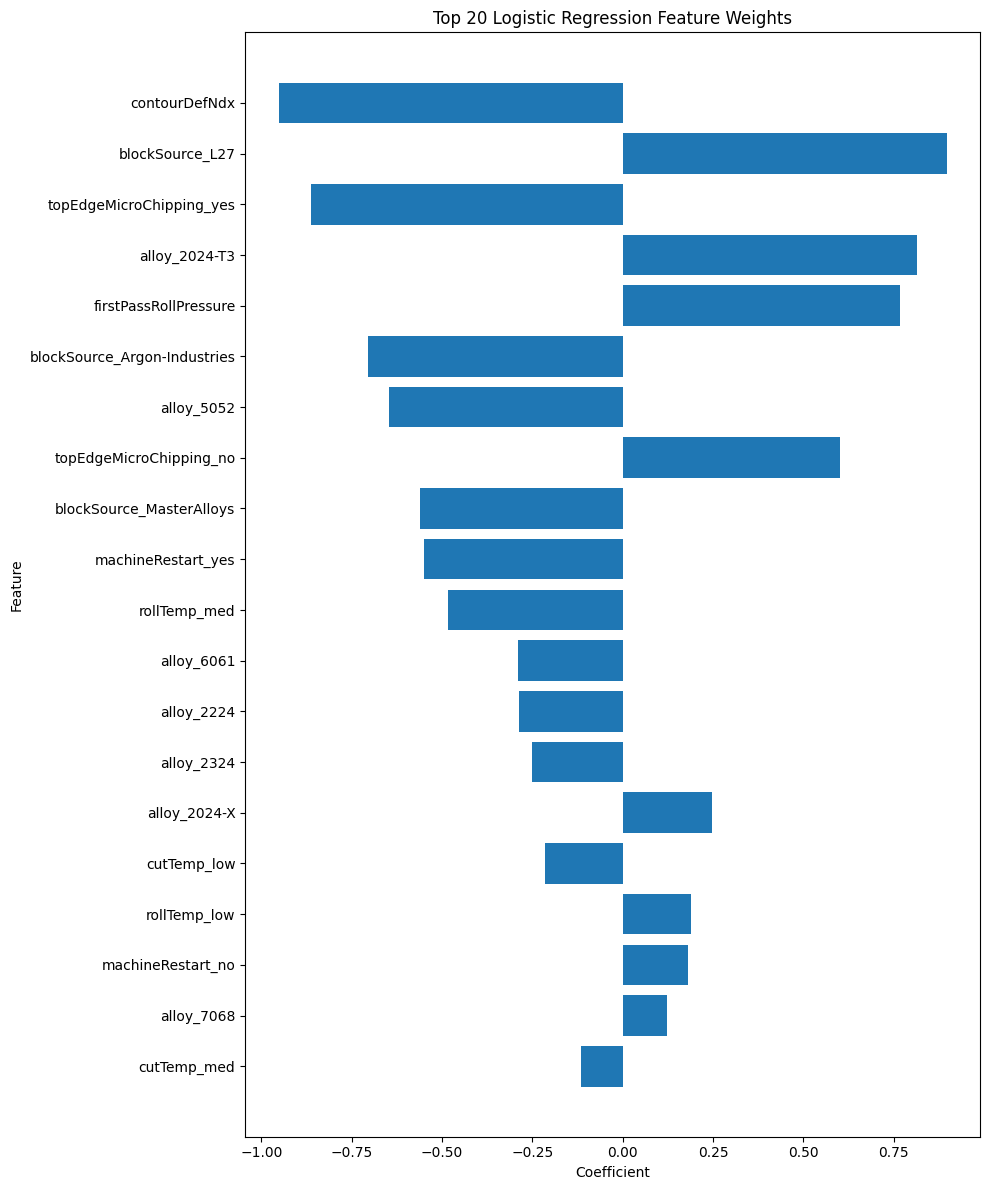

In [23]:
import matplotlib.pyplot as plt

# Fit logistic regression fully (already done in evaluation, but ensure refit)
log_reg_model.fit(X, y)

# ----------------------------
# Extract feature names
# ----------------------------

# Get names from the preprocessor
ohe = log_reg_model.named_steps["preprocess"].named_transformers_["cat"]
ohe_features = ohe.get_feature_names_out(categorical_cols)

num_features = numeric_cols.tolist()

all_features = np.concatenate([ohe_features, num_features])

# ----------------------------
# Extract coefficients
# ----------------------------

logreg = log_reg_model.named_steps["clf"]
coefs = logreg.coef_[0]   # shape: (n_features,)

# Create a DataFrame
coef_df = pd.DataFrame({
    "feature": all_features,
    "coef": coefs
})

# Sort by magnitude
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

# ----------------------------
# Plot top 20 strongest features
# ----------------------------

plt.figure(figsize=(10, 12))
plt.barh(coef_df["feature"].iloc[:20][::-1], 
         coef_df["coef"].iloc[:20][::-1])
plt.title("Top 20 Logistic Regression Feature Weights")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
example = pd.read_csv("data/aluminum_coldRoll_example.csv")
test = pd.read_csv("data/aluminum_coldRoll_testNoY.csv")
train = pd.read_csv("data/aluminum_coldRoll_train.csv")

In [19]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, make_scorer
import numpy as np

# ----------------------------
# LOAD DATA
# ----------------------------
df = train  # replace with your dataframe variable

X = df.drop(columns=["y_passXtremeDurability"])
y = df["y_passXtremeDurability"]

# ----------------------------
# PREPROCESSING
# ----------------------------
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols)
    ]
)

# ----------------------------
# DEFINE MODELS
# ----------------------------

log_reg_model = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=500))
])

rf_model = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=200, 
        random_state=42))
])

# ----------------------------
# LOG LOSS SCORER (NEGATIVE BECAUSE SKLEARN MAXIMIZES SCORING)
# ----------------------------
log_loss_scorer = make_scorer(log_loss, needs_proba=True, greater_is_better=False)

# ----------------------------
# K-FOLD LOG LOSS EVALUATION
# ----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_log_loss(model, name):
    print(f"\n==============================")
    print(f" {name} – LOG LOSS (5-Fold)")
    print("==============================")

    # sklearn returns negative log loss → multiply by -1
    scores = cross_val_score(
        model, X, y,
        cv=kf,
        scoring=log_loss_scorer
    )

    final_scores = -scores  # convert to positive log loss
    
    print("Fold LogLoss:", final_scores)
    print("Mean LogLoss:", final_scores.mean())
    print("StdDev:", final_scores.std())

# ----------------------------
# RUN BOTH MODELS
# ----------------------------
evaluate_log_loss(log_reg_model, "Logistic Regression")
evaluate_log_loss(rf_model, "Random Forest")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(



 Logistic Regression – LOG LOSS (5-Fold)
Fold LogLoss: [0.51254822 0.50920821 0.51209186 0.50503631 0.50752664]
Mean LogLoss: 0.5092822496279122
StdDev: 0.0028169558676675193

 Random Forest – LOG LOSS (5-Fold)
Fold LogLoss: [0.46795802 0.46576121 0.46773064 0.45944696 0.46109465]
Mean LogLoss: 0.4643982968880741
StdDev: 0.003494667470492366


In [8]:
import pandas as pd

# ----------------------------
# LOAD TRAIN AND TEST
# ----------------------------
train_df = train  # your training df
test_df = test    # load your actual test df

X_train = train_df.drop(columns=["y_passXtremeDurability"])
y_train = train_df["y_passXtremeDurability"]

X_test = test_df.copy()

# ----------------------------
# FIT RANDOM FOREST ON FULL TRAIN SET
# ----------------------------
rf_model.fit(X_train, y_train)

# ----------------------------
# PREDICT PROBABILITIES FOR THE KAGGLE SUBMISSION
# ----------------------------
test_probs = rf_model.predict_proba(X_test)[:, 1]

# ----------------------------
# BUILD SUBMISSION FILE
# ----------------------------
submission = pd.DataFrame({
    "ID": test_df["ID"],
    "y_passXtremeDurability": test_probs
})

# SAVE
submission.to_csv("submission.csv", index=False)

print("Submission file saved as submission.csv")
submission.head()


Submission file saved as submission.csv


,ID,y_passXtremeDurability
0,160001,0.175
1,160002,0.125
2,160003,0.750
3,160004,0.610
4,160005,0.795


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, make_scorer
from xgboost import XGBClassifier

# ----------------------------
# LOAD DATA
# ----------------------------
train_df = train     # your training DF
test_df  = test      # your test DF

X = train_df.drop(columns=["y_passXtremeDurability"])
y = train_df["y_passXtremeDurability"]

# ----------------------------
# PREPROCESSING
# ----------------------------
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols      = X.select_dtypes(include=["int64", "float64"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols)
    ]
)

# ----------------------------
# XGBOOST MODEL
# ----------------------------
xgb_model = Pipeline([
    ("prep", preprocessor),
    ("clf", XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ))
])

# ----------------------------
# LOG LOSS (K-Fold)
# ----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
log_loss_scorer = make_scorer(log_loss, needs_proba=True, greater_is_better=False)

scores = cross_val_score(
    xgb_model, X, y,
    cv=kf,
    scoring=log_loss_scorer
)

final_scores = -scores
print("\n===== XGBOOST LOG LOSS (5-fold) =====")
print("Fold LogLoss:", final_scores)
print("Mean LogLoss:", final_scores.mean())
print("StdDev:", final_scores.std())

# ----------------------------
# TRAIN FINAL MODEL ON FULL DATA
# ----------------------------
xgb_model.fit(X, y)




/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(



===== XGBOOST LOG LOSS (5-fold) =====
Fold LogLoss: [0.43295295 0.42907535 0.43017473 0.41988212 0.42408507]
Mean LogLoss: 0.42723404589131275
StdDev: 0.004662848501546232


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['alloy', 'cutTemp', 'rollTemp', 'topEdgeMicroChipping', 'blockSource',
       'machineRestart'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ID', 'firstPassRollPressure', 'secondPassRollPressure',
       'contourDefNdx', 'clearPassNdx'],
      dtype='object'))])),
                ('c...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [17]:
# ----------------------------
# MAKE KAGGLE SUBMISSION
# ----------------------------
X_test = test_df.copy()

test_probs = xgb_model.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    "ID": test_df["ID"],
    "y_passXtremeDurability": test_probs
})

submission.to_csv("submission_xgb.csv", index=False)
print("Saved submission_xgb.csv")
submission.head()

Saved submission_xgb.csv


,ID,y_passXtremeDurability
0,160001,0.004454
1,160002,0.095268
2,160003,0.956373
3,160004,0.676737
4,160005,0.818818


In [18]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 900),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }

    model = Pipeline([
        ("prep", preprocessor),
        ("clf", XGBClassifier(
            eval_metric="logloss",
            random_state=42,
            **params
        ))
    ])

    scores = cross_val_score(
        model, X, y,
        cv=5,
        scoring=log_loss_scorer
    )

    return -scores.mean()  # minimize log loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("BEST PARAMS:", study.best_params)
print("BEST LOG LOSS:", study.best_value)



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-11-20 13:28:56,905] A new study created in memory with name: no-name-253f414f-fd6e-4477-b06c-6ceebfc15ff5
[I 2025-11-20 13:29:00,224] Trial 0 finished with value: 0.43224705883306325 and parameters: {'n_estimators': 202, 'learning_rate': 0.13133897130827932, 'max_depth': 8, 'subsample': 0.5271105129753086, 'colsample_bytree': 0.910782376117621, 'gamma': 3.6564725183433078, 'min_child_weight': 4}. Best is trial 0 with value: 0.43224705883306325.
[I 2025-11-20 13:29:08,460] Trial 1 finished with value: 0.428537599012856 and parameters: {'n_estimators': 750, 'learning_rate': 0.043948063185479766, 'max_depth': 5, 'subsample': 0.838046040583691, 'colsample_bytree': 0.9606773541147116, 'gamma': 1.8640961

BEST PARAMS: {'n_estimators': 769, 'learning_rate': 0.11130804298183121, 'max_depth': 4, 'subsample': 0.9695152484894143, 'colsample_bytree': 0.9754978301881636, 'gamma': 4.9640185298931945, 'min_child_weight': 1}
BEST LOG LOSS: 0.42509543214003254


In [22]:
best_params


{'n_estimators': 769,
 'learning_rate': 0.11130804298183121,
 'max_depth': 4,
 'subsample': 0.9695152484894143,
 'colsample_bytree': 0.9754978301881636,
 'gamma': 4.9640185298931945,
 'min_child_weight': 1}

In [19]:
best_params = study.best_params
final_model = Pipeline([
    ("prep", preprocessor),
    ("clf", XGBClassifier(
        eval_metric="logloss",
        random_state=42,
        **best_params
    ))
])
final_model.fit(X, y)
test_probs = final_model.predict_proba(test_df)[:, 1]
submission = pd.DataFrame({
    "ID": test_df["ID"],
    "y_passXtremeDurability": test_probs
})

submission.to_csv("submission_optuna_xgb.csv", index=False)
print("Saved submission_optuna_xgb.csv")


Saved submission_optuna_xgb.csv
